In [3]:
using Pkg; Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/research/SolidStateFormationFlying`


In [4]:
import SatelliteDynamics

include("../src/satellite_simulator.jl")
include("../src/detumble_controller.jl")
include("../src/satellite_models.jl")

using Plots
gr()

Plots.GRBackend()

# Satellite Detumbling
When deployed on-orbit, a satellite can have an undesired angular velocity. In the first stage of commissioning the satellite it is common to autonomously detumble it using electromagnetic coils known as magnetorquers. 
There are two common control methods used for detumbling a satellite, known as B-dot and B-cross control.
Neither of these methods explicity account for the physical saturation limits of the magnetorquers. In 1978, Markley published a method that accounts for the saturation limits of magnetorquers. The controller is given without proof of convergence and in a form that we found is subject to chattering. 
We investigate these controllers and derive a time-optimal detumbling controller in the following.

# Background

## Angular velocity dynamics
We let $\omega \in \mathbb{R}^3$ be the angular velocity of a single rigid body with inertia matrix $J \in \mathbb{R}^{3 \times 3}$. Its time derivative is
$$
\dot{\omega} = J^{-1} (\tau - \omega_\times  J \omega)
$$
where $\tau \in \mathbb{R}^3$ is the applied torque and 
$$
\omega_\times = \begin{bmatrix} 0 & -\omega_3 & \omega_2 \\ \omega_3 & 0 & -\omega_1 \\ -\omega_2 & \omega_1 & 0 \end{bmatrix}
$$
is the matrix representation of the cross product.

## Electromagnetic torque
We assume the satellite is able to produce a magnetic dipole $m \in \mathbb{R}^3$ in the range $-m_\mathrm{max} \leq m \leq m_\mathrm{max}$, where $m_\mathrm{max} \in \mathbb{R}^3$.
This dipole reacts with the local magnetic field of the Earth, $B \in \mathbb{R}^3$ to produce a torque
$$
\tau = m_\times B.
$$



## B-dot control

## B-cross control


## Time-optimal detumbling
To derive the time-optimal detumbling, we begin with defining the rotational kinetic energy as a Lyapunov function
$$
V = \frac12 \omega^T J \omega,
$$
which is positive-definite and zero when $\omega = 0$.
Taking the time derivative and substituting from above, we have
\begin{align*}
\dot{V} &= \omega^T J \dot{\omega} \\
&= \omega^T J J^{-1} (\tau - \omega_\times J \omega) \\
&= \omega^T J J^{-1} (m_\times B - \omega_\times J \omega) \\
&= \omega^T m_\times B - \omega^T \omega_\times J \omega\\
&= \omega^T m_\times B 
\end{align*}
since $\omega^T \omega_\times = \omega_\times^T \omega = -\omega_\times \omega = 0$.
Using scalar triple product and cross product identities, we have
\begin{align*}
\dot{V} = \omega^T m_\times B = B^T \omega_\times m = (B_\times \omega)^T m.
\end{align*}
We can see that $\dot{V}$ is only negative-semidefinite in $\omega$ and $m$ since if $\omega = \beta B$ for some $\beta \in \mathbb{R}$, $B_\times \omega = B_\times \beta B = 0$. 
Since $B$ is time varying along a satellite's orbit, this condition would persist only when $B = \beta \omega$ and $\dot{B} = \dot{\omega}$ which forms a set of measure zero and would occur almost never.

To find the time-optimal detumbling control law for $m$ that satisifies the constraints $-m_\mathrm{max} \leq m \leq m_\mathrm{max}$, we must solve
\begin{align*}
&\argmin_m &&  \dot{V} = (B_\times \omega)^T m \\
&\mathrm{s.t.} && -m_\mathrm{max} \leq m \leq m_\mathrm{max}.
\end{align*}
This is a linear program in $m$ and has the solution 
\begin{align*}
m = - m_\mathrm{max} \; \mathrm{sign}(B_\times \omega)
\end{align*}

This is the control law presented by Markley (1978).

In practice, this suffers from chattering as $B_\times \omega \to 0$.
For this reason, we smooth the time-optimal control law to be
\begin{align*}
m = - m_\mathrm{max} \; \tanh(k b_\times \omega)
\end{align*}
where $k > 0$ is a tuning parameter and $b = B/\|B\|$. 


------
# Simulation Experiments

In [5]:
params = OrbitDynamicsParameters(py4_model;
    distance_scale=1.0,
    time_scale=1.0,
    angular_rate_scale=1.0,
    control_scale=1,
    control_type=:dipole,
    magnetic_model=:IGRF13,
    add_solar_radiation_pressure=true,
    add_sun_thirdbody=true,
    add_moon_thirdbody=true)

# x_osc_0 = [400e3 + SatelliteDynamics.R_EARTH, 0.0, deg2rad(50), deg2rad(-1.0), 0.0, 0.0] # a, e, i, Ω, ω, M
x_osc_0 = [525e3 + SatelliteDynamics.R_EARTH, 0.0001, deg2rad(97.6), deg2rad(-1.0), 0.0, 45.0] # a, e, i, Ω, ω, M
q0 = [1.0, 0.0, 0.0, 0.0]
ω0 = [deg2rad(20), deg2rad(-30), deg2rad(10)]

tspan = (0.0, 5 * 60 * 60.0)
x0 = state_from_osc(x_osc_0, q0, ω0)

13-element Vector{Float64}:
       3.611068182649912e6
 -840051.7877863818
       5.822609767771629e6
   -6474.762908926636
    -414.9620218278771
    3956.4190910405464
       1.0
       0.0
       0.0
       0.0
       0.3490658503988659
      -0.5235987755982988
       0.17453292519943295

## B-Cross

The B-Cross controller is studied extensively in [Magnetic Detumbling of a Rigid Spacecraft](https://arc.aiaa.org/doi/10.2514/1.53074). 

As part of their development, they suggest an optimal gain. The gain trades off between two undesireable scenarios. If the gain is too large, the controller will cause fast convergence to an angular rate that is parallel to the Earth's magnetic field. Angular rates in this direction are not controllable on short timeframes and require the Earth's magnetic field to vary in order to detumble. If the gain is too small, the controller simply takes a long time to converge.

The optimal gain, from eq 30, is
$$
k_\omega = 2 \Omega (1 + \sin(\xi_m)) J_\mathrm{min}
$$
where $\Omega = 2\pi / T$, with $T = 2 \pi \sqrt{a^3 / \mu}$ being the orbital period, $\xi_m$ is the inclination of the satellite wrt the geomagnetic equator (I used the inclination), and $J_\mathrm{min}$ is the smallest principle moment of inertia.

In [6]:
k_bcross = bcross_gain(x_osc_0, params)

4.3837672082212475e-6

In [7]:
xhist_bcross, uhist_bcross, thist_bcross = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> bcross_control(x, t, m; k=k_bcross, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117469296203535e6 -2.812440949318249e6; -840051.7877863818 -840093.2788911278 … -777337.5018780363 -777282.6453031541; … ; -0.5235987755982988 -0.515020378323305 … -2.18933746833793e-5 -2.1895185620258313e-5; 0.17453292519943295 0.18198945338412165 … 7.399753552045258e-5 7.39967437052764e-5], [0.03292483531736253 0.030976864785505875 … -1.5739543425031908e-6 -1.5739543425031908e-6; 0.012878522873240488 0.012080642698037295 … 1.3614231189795818e-6 1.3614231189795818e-6; -0.0272141020150036 -0.028376315515762723 … 4.3179203563691377e-7 4.3179203563691377e-7], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

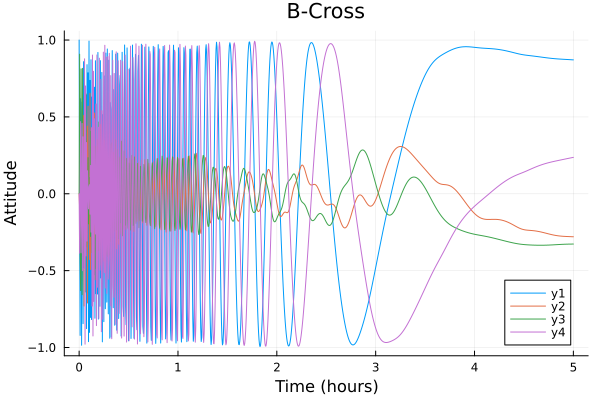

In [8]:
plot_attitude(thist_bcross, xhist_bcross; title="B-Cross")

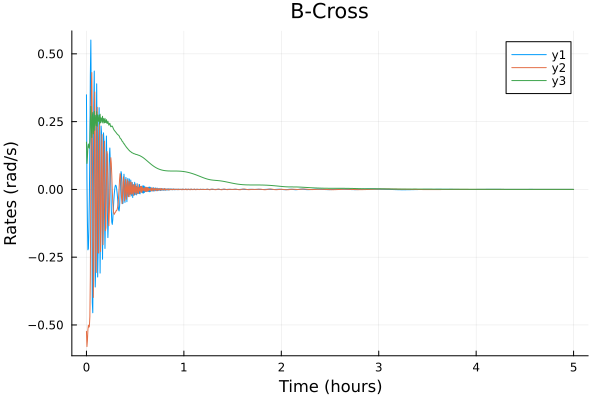

In [9]:
plot_rates(thist_bcross, xhist_bcross; title="B-Cross")

In [10]:
plot_controls(thist_bcross, uhist_bcross; title="B-Cross")

MethodError: MethodError: no method matching plot_controls(::Vector{Float64}, ::Matrix{Float64}; title="B-Cross")
Closest candidates are:
  plot_controls(::Any, ::Any, !Matched::Any; max_samples, title) at ~/research/SolidStateFormationFlying/src/satellite_simulator.jl:667

## Time Optimal

In [11]:
k_bopt = 1.5e3
xhist_bopt, uhist_bopt, thist_bopt = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> boptimal_control(x, t, m; k=k_bopt, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.811777870526265e6 -2.8124718888793797e6; -840051.7877863818 -840093.2788911278 … -777334.5149335777 -777279.6578998471; … ; -0.5235987755982988 -0.5149382850128278 … -0.0016011023565892398 -0.0016044969446082748; 0.17453292519943295 0.18201942418815104 … 0.055303759037920855 0.05530370429463831], [0.06997731147540984 0.06997731147540984 … -0.0049357188913627574 -0.0049357188913627574; 0.053130000000000004 0.053130000000000004 … 0.0063752163824389455 0.0063752163824389455; -0.06976756111111111 -0.06976756111111111 … 0.000286368404874978 0.000286368404874978], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

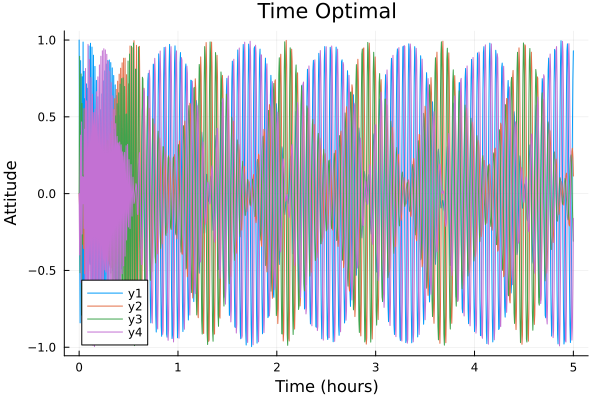

In [12]:
plot_attitude(thist_bopt, xhist_bopt; title="Time Optimal")

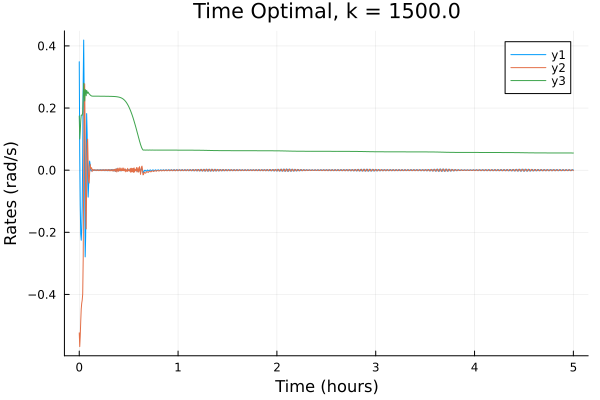

In [13]:
plot_rates(thist_bopt, xhist_bopt; title="Time Optimal, k = $k_bopt")

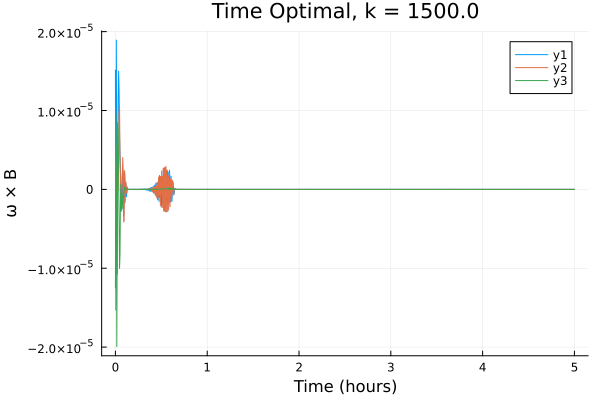

In [14]:
plot_omega_cross_B(thist_bopt, xhist_bopt, params; title="Time Optimal, k = $k_bopt")

In [15]:
plot_controls(thist_bopt, uhist_bopt; title="Time Optimal")


MethodError: MethodError: no method matching plot_controls(::Vector{Float64}, ::Matrix{Float64}; title="Time Optimal")
Closest candidates are:
  plot_controls(::Any, ::Any, !Matched::Any; max_samples, title) at ~/research/SolidStateFormationFlying/src/satellite_simulator.jl:667

## Time Optimal - Ball constrained

In [16]:
k_bopt = 1.5e3
xhist_bopt, uhist_bopt, thist_bopt = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> boptimal_control_ball(x, t, m; k=k_bopt, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117769415857815e6 -2.8124709599658465e6; -840051.7877863818 -840093.2788911278 … -777334.6338290422 -777279.7768129533; … ; -0.5235987755982988 -0.5149848782363982 … 0.0015355552950256572 0.0015360018531435239; 0.17453292519943295 0.18199414574701134 … 0.017627930178493904 0.017627908590693415], [0.05164149996473121 0.04959016373557468 … 0.0005312053746224417 0.0005312053746224417; 0.01533641505285224 0.014684830936366711 … -0.001992087298591907 -0.001992087298591907; -0.042556463840417245 -0.045290181905790754 … 0.00023169311835681964 0.00023169311835681964], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

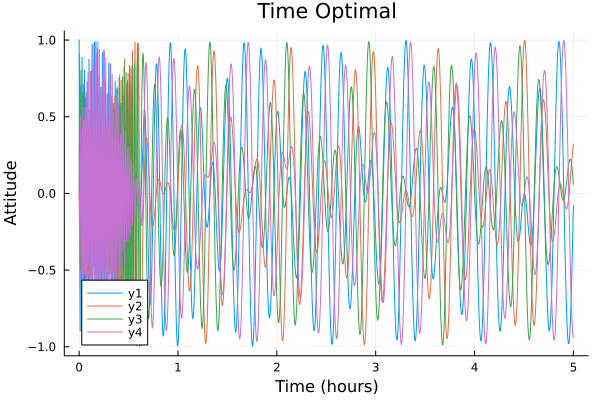

In [17]:
plot_attitude(thist_bopt, xhist_bopt; title="Time Optimal")

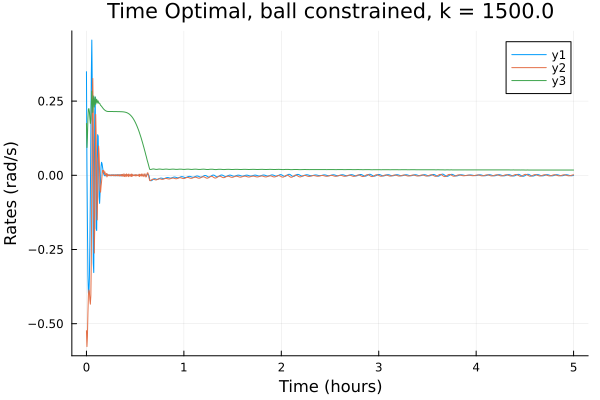

In [18]:
plot_rates(thist_bopt, xhist_bopt; title="Time Optimal, ball constrained, k = $k_bopt")

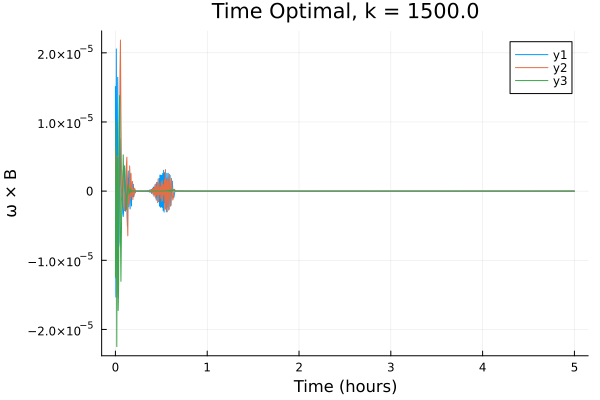

In [19]:
plot_omega_cross_B(thist_bopt, xhist_bopt, params; title="Time Optimal, k = $k_bopt")

In [20]:
plot_controls(thist_bopt, uhist_bopt; title="Time Optimal")


MethodError: MethodError: no method matching plot_controls(::Vector{Float64}, ::Matrix{Float64}; title="Time Optimal")
Closest candidates are:
  plot_controls(::Any, ::Any, !Matched::Any; max_samples, title) at ~/research/SolidStateFormationFlying/src/satellite_simulator.jl:667

------
# Time-optimal momentum control
We found that the B-cross controller exhibits an odd behavior as the gain increases. The major axis of the satellite aligns with the B-field vector and the angular velocity in that direction doesn't get canceled.
Rather than use angular velocity in the controller formulation, I decided to try deriving the controller using momentum.

The angular momentum of a rigid body with inertia $J$ and angular velocity $\omega$ is
$$
h = J \omega.
$$
Recalling that
$$
J \dot{\omega} = \tau - \omega \times J \omega,
$$
the time derivative of the angular momentum is
\begin{align}
\dot{h} &= \tau - \omega \times J \omega \\
&= \tau - \omega \times h \\
&= \tau - (J^{-1} h) \times h \\
&= \tau + h \times J^{-1} h
\end{align}
where we substituted $\omega = J^{-1} h$ and used the property $a \times b = - b \times a$.

To derive the controller, we define the positive definite Lyapunov function 
$$
V = \frac{1}{2} h^T h.
$$
Its time derivative is
\begin{align}
\dot{V} &= h^T \dot{h} \\
&= h^T (\tau + h \times J^{-1} h)\\
&= h^T \tau.
\end{align}
With magnetorquer control, $\tau = m \times B$, so we have
\begin{align}
\dot{V} = h^T \tau = h^T (m \times B) = B^T h \times m.
\end{align}

This has the same form as the angular rate control, so we know that the minimum time control law is 
\begin{align*}
m = - m_\mathrm{max} \; \mathrm{sign}(B_\times h)
\end{align*}
and the smooth law is 
\begin{align*}
m = - m_\mathrm{max} \; \tanh(k b_\times h)
\end{align*}
where $k > 0$ is a tuning parameter and $b = B/\|B\|$. 

In [21]:
k_momentum = 2e3
xhist_momentum, uhist_momentum, thist_momentum = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> bmomentum_control(x, t, m; k=k_momentum, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117959907740206e6 -2.812490008022045e6; -840051.7877863818 -840093.2788911278 … -777333.0060116107 -777278.1486790245; … ; -0.5235987755982988 -0.5149424919584683 … 1.686168846145933e-9 1.6861476002735061e-9; 0.17453292519943295 0.18196966204564832 … -2.4070670169084234e-10 -2.40552611227219e-10], [0.0667762054785098 0.06595864247112766 … -1.8320749849467225e-10 -1.8320749849467225e-10; -0.031152206320982697 -0.03453881938476013 … -1.3974856423210652e-11 -1.3974856423210652e-11; -0.06705641098025547 -0.06739317366330554 … -9.882643152637364e-11 -9.882643152637364e-11], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

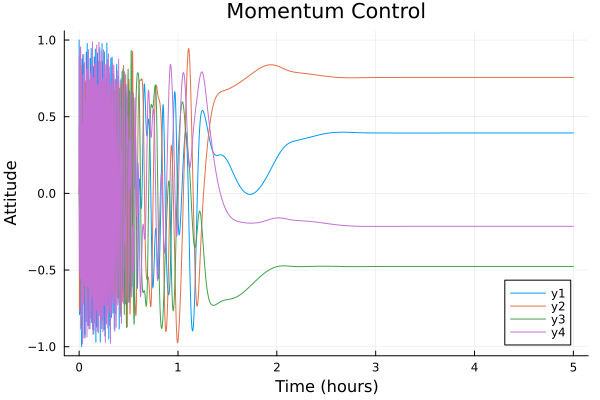

In [22]:
plot_attitude(thist_momentum, xhist_momentum; title="Momentum Control", max_samples=3600)

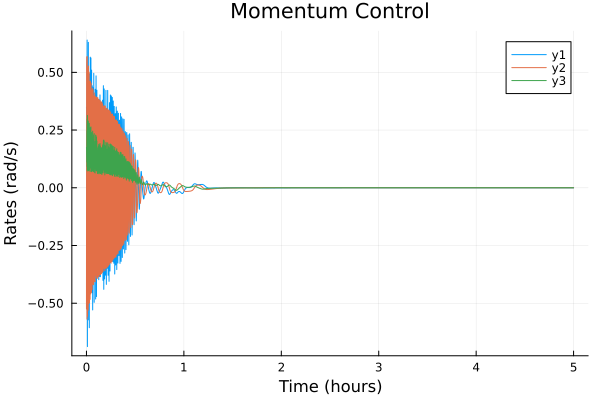

In [23]:
plot_rates(thist_momentum, xhist_momentum; title="Momentum Control", max_samples=3600)

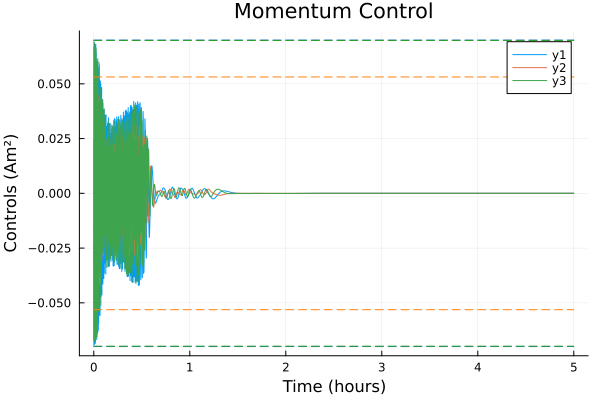

In [24]:
plot_controls(thist_momentum, uhist_momentum, params; title="Momentum Control", max_samples=3600)